In [12]:
import os
import pickle
import math
import hmmlearn.hmm as hmm
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib import cm
import librosa
import seaborn as sns
from pydub import AudioSegment, effects
from scipy.io.wavfile import write, read

In [13]:
class_names = ['amluongmottram','amluongnammuoi', 'baitieptheo','baitruocdo','batnhac','dunglai','meimei','phatlaplai','phatngaunhien','phattuantu','tatam','tualui','tuatoi']
states = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dataset_path = 'dataset_final'
X = {'train': {}, 'test': {}}
y = {'train': {}, 'test': {}}
model = {}
model_path = 'new_model_5'

In [14]:
def detect_leading_silence(sound, silence_threshold=-19.0, chunk_size=10):
        trim_ms = 0  

        assert chunk_size > 0  
        while sound[trim_ms:trim_ms + chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
            trim_ms += chunk_size

        return trim_ms

In [15]:
def get_mfcc(file_path):    
    trimmed_path = 'temp/trimmed.wav'
    sound = AudioSegment.from_file(file_path, format='wav')
    normalizedsound = effects.normalize(sound)
    normalizedsound.export(trimmed_path, format='wav')

    rate, data = read(trimmed_path)
    write(trimmed_path, rate, data)

    sound = AudioSegment.from_file(trimmed_path, format='wav')
    start_trim = detect_leading_silence(sound)
    end_trim = detect_leading_silence(sound.reverse())

    duration = len(sound)
    print(file_path)
    print(str(start_trim) + " - " + str(duration - end_trim))

    trimmed_sound = sound[start_trim:duration - end_trim]
    trimmed_sound.export(trimmed_path, format='wav')


    y, sr = librosa.load(trimmed_path)  
    hop_length = math.floor(sr * 0.010)  
    win_length = math.floor(sr * 0.025)  
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, n_fft=1024,hop_length=hop_length, win_length=win_length)
    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1, 1))
    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)
    X = np.concatenate([mfcc, delta1, delta2], axis=0)  
    return X.T  

In [16]:
def print_avg_mfcc(all_data, class_names):
    for cname in class_names:
        max_len = 0
        for mfcc in all_data[cname]:
            if len(mfcc) > max_len:
                max_len = len(mfcc)
        all_padded_mfcc = []
        for mfcc in all_data[cname]:
            padded_mfcc = np.pad(mfcc, ((0, max_len - len(mfcc)), (0, 0)), mode='constant')
            all_padded_mfcc.append(padded_mfcc)
        avg_mfcc = np.mean(all_padded_mfcc, axis=0)
        fig, ax = plt.subplots()
        cax = ax.imshow(avg_mfcc.T, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
        ax.set_title(f"Average MFCC for {cname}")
        plt.show()


In [17]:
length = 0
for cn in class_names:
    length += len(os.listdir(f"{dataset_path}/{cn}"))
print('Total samples:', length)

all_data = {}
all_labels = {}
for cname in class_names:
    file_paths = [os.path.join(dataset_path, cname, i) for i in os.listdir(
        os.path.join(dataset_path, cname)) if i.endswith('.wav')]
    data = [get_mfcc(file_path) for file_path in file_paths]
    all_data[cname] = data
    all_labels[cname] = [class_names.index(cname) for _ in range(len(file_paths))]


Total samples: 907
dataset_final\amluongmottram\al100_minh0.wav
470 - 1370
dataset_final\amluongmottram\al100_minh1.wav
520 - 1360
dataset_final\amluongmottram\al100_minh10.wav
420 - 970
dataset_final\amluongmottram\al100_minh11.wav
330 - 940
dataset_final\amluongmottram\al100_minh12.wav
430 - 880
dataset_final\amluongmottram\al100_minh13.wav
330 - 1020
dataset_final\amluongmottram\al100_minh14.wav
370 - 1070
dataset_final\amluongmottram\al100_minh15.wav
680 - 1170
dataset_final\amluongmottram\al100_minh16.wav
510 - 1260
dataset_final\amluongmottram\al100_minh17.wav
530 - 1340
dataset_final\amluongmottram\al100_minh18.wav
430 - 1220
dataset_final\amluongmottram\al100_minh19.wav
380 - 1150
dataset_final\amluongmottram\al100_minh2.wav
470 - 1310
dataset_final\amluongmottram\al100_minh20.wav
0 - 1490
dataset_final\amluongmottram\al100_minh21.wav
90 - 1090
dataset_final\amluongmottram\al100_minh3.wav
450 - 1200
dataset_final\amluongmottram\al100_minh4.wav
390 - 970
dataset_final\amluongmot

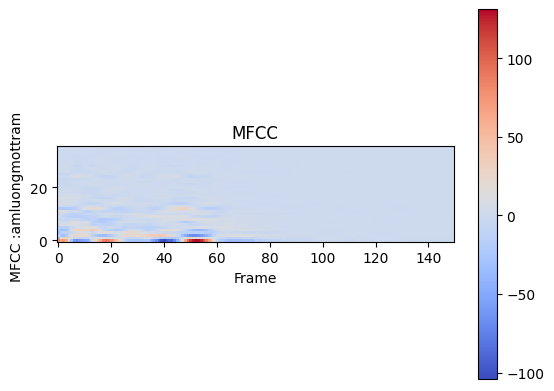

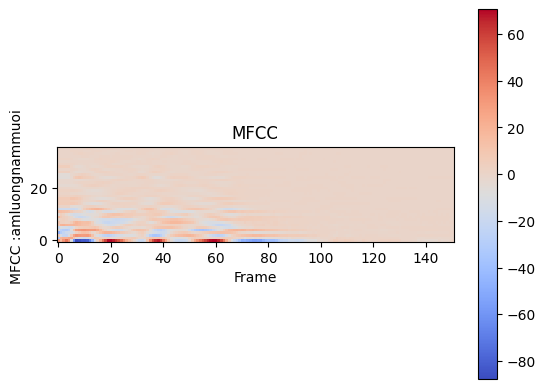

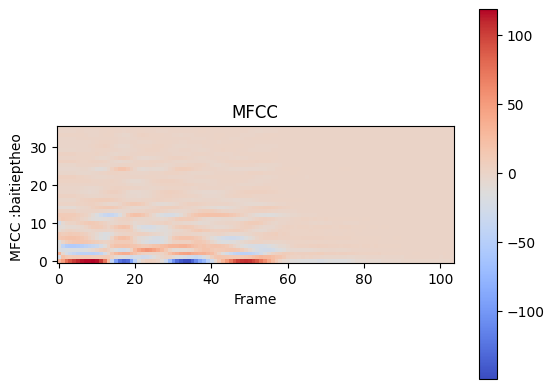

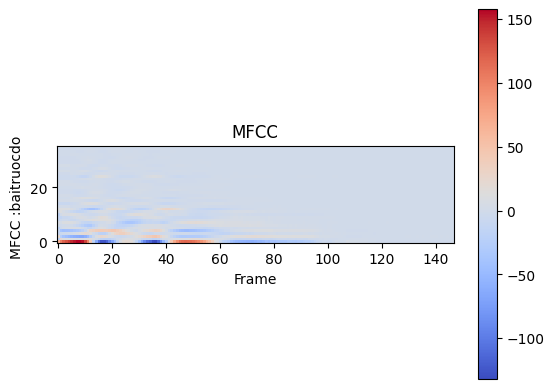

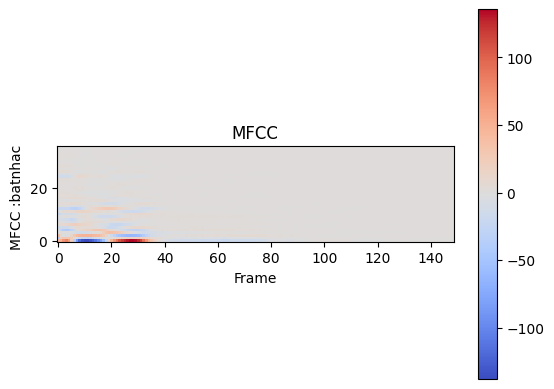

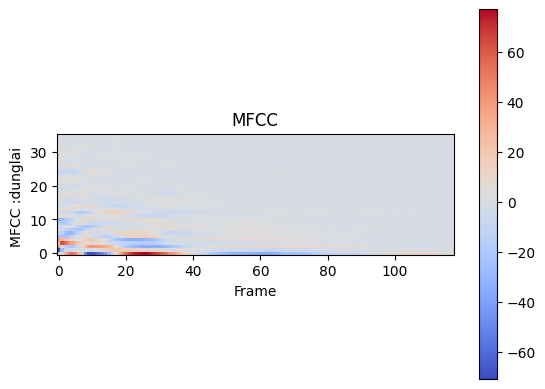

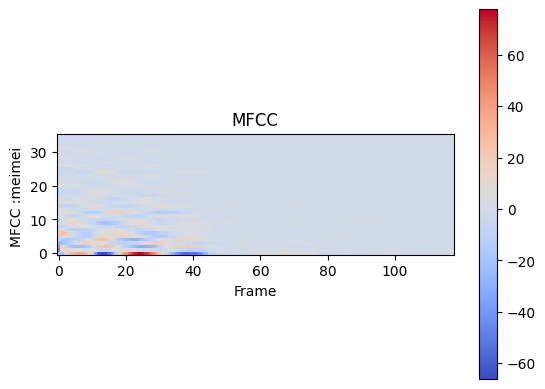

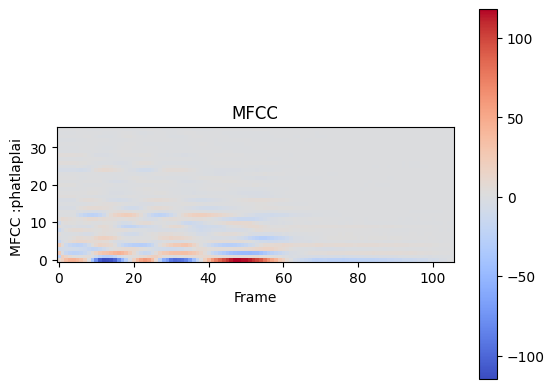

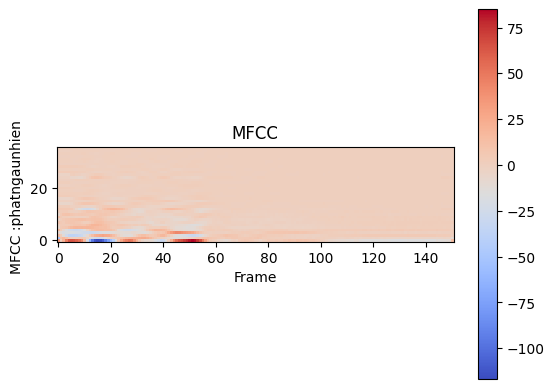

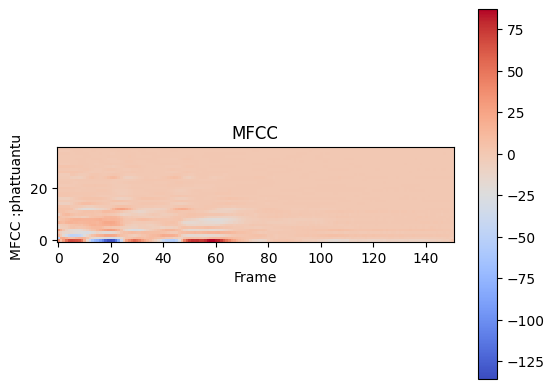

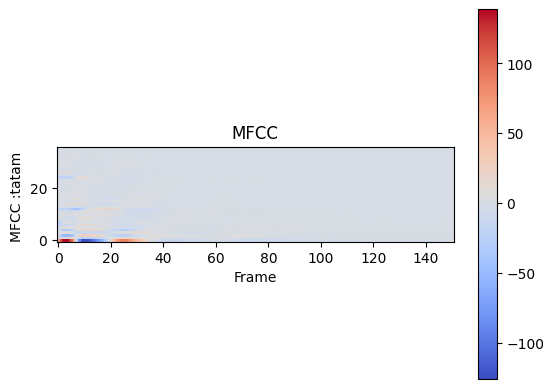

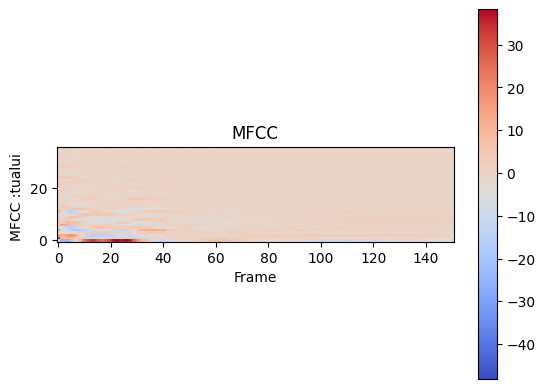

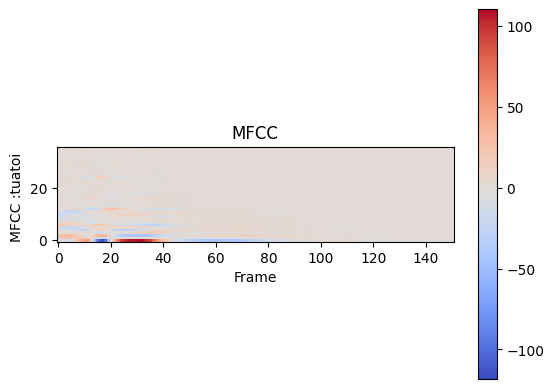

In [18]:
avg_mfcc = {}
for cname in all_data.keys():
    data = all_data[cname]
    padded_mfcc = np.zeros((len(data), max([d.shape[0] for d in data]), 36))
    for i in range(len(data)):
        mfcc = data[i]
        padded_mfcc[i, :mfcc.shape[0], :] = mfcc
    avg_mfcc[cname] = np.mean(padded_mfcc, axis=0)
for cname in class_names:
    #print(f'Label: {cname} Average MFCC: {avg_mfcc[cname]}' )
    plt.imshow(avg_mfcc[cname].T, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
    plt.title('MFCC')
    plt.xlabel('Frame')
    plt.ylabel(f'MFCC :{cname} ')
    plt.colorbar()
    plt.show()

amluongmottram train: 47 | test: 21
amluongnammuoi train: 51 | test: 22
baitieptheo train: 37 | test: 17
baitruocdo train: 44 | test: 20
batnhac train: 53 | test: 23
dunglai train: 46 | test: 21
meimei train: 46 | test: 21
phatlaplai train: 51 | test: 22
phatngaunhien train: 53 | test: 24
phattuantu train: 44 | test: 20
tatam train: 59 | test: 26
tualui train: 49 | test: 21
tuatoi train: 48 | test: 21
train samples: 628
test samples 279
amluongmottram
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         1 -362635.46724828             +nan
         2 -352816.00833109   +9819.45891719
         3 -352268.72121010    +547.28712099
         4 -352208.54035705     +60.18085305
         5 -352187.40232910     +21.13802796
         6 -352164.47478976     +22.92753934
         7 -352136.48547839     +27.98931137
         8 -352105.01968347     +31.46579492
         9 -352077.23797739     +27.78170608
        10 -352053.05535982     +24.18261757
        11 -352023.35518868     +29.70017114
        12 -351987.45436776     +35.90082092
        13 -351956.34763439     +31.10673336
        14 -351918.30014449     +38.04748990
        15 -351849.30707352     +68.99307097
        16 -351790.75993261     +58.54714092
        17 -351768.42823835     +22.33169425
        18 -351744.32120993     +24.10702842
        19 -351721.34824035     +22.97296958
        20 -351695.57006042     +25.77817993
        21 -351649.60756327     +45.96249715
        22 -351559.53736317     +90.07020010
        23

amluongnammuoi
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         7 -418420.61449252    +159.23906187
         8 -418395.43886964     +25.17562287
         9 -418389.96430902      +5.47456063
        10 -418387.97138882      +1.99292020
        11 -418387.11741295      +0.85397587
        12 -418386.73319649      +0.38421646
        13 -418386.55145613      +0.18174036
        14 -418386.45936586      +0.09209027
        15 -418386.40903927      +0.05032659
        16 -418386.37930548      +0.02973379
        17 -418386.36034780      +0.01895768
        18 -418386.34742986      +0.01291793
        19 -418386.33818835      +0.00924151
         1 -249352.40939627             +nan
         2 -240106.83455726   +9245.57483901
         3 -239525.54422980    +581.29032746
         4 -239283.70447662    +241.83975317
         5 -239091.05590329    +192.64857333
         6 -238889.17505414    +201.88084915
         7 -238746.13077260    +143.04428154
         8 -238644.69927030    +101.43150230


baitieptheo
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         9 -238550.01213458     +94.68713571
        10 -238444.60823489    +105.40389969
        11 -238304.48010960    +140.12812529
        12 -238053.02997362    +251.45013598
        13 -237633.88001870    +419.14995492
        14 -237133.72038177    +500.15963694
        15 -236411.69601211    +722.02436966
        16 -236005.71181275    +405.98419936
        17 -235921.63055013     +84.08126262
        18 -235896.40372482     +25.22682531
        19 -235878.50377569     +17.89994913
        20 -235858.50619865     +19.99757704
        21 -235838.19795737     +20.30824128
        22 -235826.51040908     +11.68754829
        23 -235821.53692782      +4.97348126
        24 -235819.53715830      +1.99976952
        25 -235818.72995985      +0.80719845
        26 -235818.39348121      +0.33647864
        27 -235818.25221260      +0.14126860
        28 -235818.19269146      +0.05952114
        29 -235818.16712654      +0.02556492
        30 -235818.15581224      +0.01131430
        31

baitruocdo
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]
batnhac
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         5 -342538.07632154    +129.74406619
         6 -342494.44663520     +43.62968634
         7 -342473.15888507     +21.28775013
         8 -342463.76517641      +9.39370866
         9 -342461.57382067      +2.19135574
        10 -342460.64543483      +0.92838585
        11 -342460.07869362      +0.56674121
        12 -342459.70461474      +0.37407888
        13 -342459.46927504      +0.23533970
        14 -342459.33264848      +0.13662655
        15 -342459.25862310      +0.07402538
        16 -342459.22041222      +0.03821089
        17 -342459.20130487      +0.01910734
        18 -342459.19194681      +0.00935806
         1 -305248.58312718             +nan
         2 -290438.05653226  +14810.52659492
         3 -288564.48348765   +1873.57304462
         4 -287500.66214155   +1063.82134609
         5 -286262.50376439   +1238.15837716
         6 -285942.18728929    +320.31647511
         7 -285785.29088147    +156.89640782
         8 -285597.86260424    +187.42827723
         9

dunglai
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]
meimei
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         8 -222458.45507527   +1967.71570579
         9 -222146.02735436    +312.42772091
        10 -221805.83960834    +340.18774602
        11 -221776.50091830     +29.33869004
        12 -221759.05645250     +17.44446580
        13 -221747.47218976     +11.58426274
        14 -221744.12135442      +3.35083533
        15 -221743.41839207      +0.70296235
        16 -221743.21815483      +0.20023724
        17 -221743.14854176      +0.06961307
        18 -221743.12166151      +0.02688025
        19 -221743.11061990      +0.01104161
        20 -221743.10588989      +0.00473001
         1 -243245.72299996             +nan
         2 -232473.32098720  +10772.40201276
         3 -229489.77332912   +2983.54765807
         4 -227372.83039966   +2116.94292946
         5 -226577.77873601    +795.05166366
         6 -226252.35859889    +325.42013711
         7 -226000.22237677    +252.13622212
         8 -225939.77886815     +60.44350862
         9 -225897.85479403     +41.92407412
        10

phatlaplai
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


        13 -334084.61903258   +1233.24100690
        14 -333729.86369994    +354.75533265
        15 -333613.32240497    +116.54129497
        16 -333573.21996715     +40.10243782
        17 -333558.86148169     +14.35848545
        18 -333552.54889291      +6.31258878
        19 -333547.71263650      +4.83625641
        20 -333543.57387157      +4.13876493
        21 -333540.26297031      +3.31090127
        22 -333537.47468615      +2.78828416
        23 -333535.01785372      +2.45683243
        24 -333532.74779569      +2.27005802
        25 -333530.38490331      +2.36289239
        26 -333527.27643390      +3.10846941
        27 -333521.53669432      +5.73973958
        28 -333508.80591215     +12.73078217
        29 -333487.18532435     +21.62058780
        30 -333435.01095877     +52.17436558
        31 -333335.67778255     +99.33317622
        32 -333246.53049079     +89.14729176
        33 -333172.54777574     +73.98271505
        34 -333121.68315091     +50.86462483
        35

phatngaunhien
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         6 -455848.30760126   +3850.60967498
         7 -451756.57916522   +4091.72843605
         8 -450822.37880946    +934.20035575
         9 -450504.29817152    +318.08063794
        10 -450242.53318538    +261.76498615
        11 -450004.98950442    +237.54368095
        12 -449753.23461584    +251.75488858
        13 -449633.46066986    +119.77394598
        14 -449593.47530661     +39.98536325
        15 -449583.98141873      +9.49388788
        16 -449581.01001475      +2.97140398
        17 -449579.29942473      +1.71059002
        18 -449578.82608354      +0.47334120
        19 -449578.72523705      +0.10084649
        20 -449578.70253726      +0.02269979
        21 -449578.69707766      +0.00545961
         1 -405160.59930193             +nan
         2 -389991.96579409  +15168.63350784
         3 -387450.51759426   +2541.44819982


phattuantu
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]
tatam
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         4 -386429.02276198   +1021.49483228
         5 -386250.29548698    +178.72727500
         6 -386202.73312916     +47.56235782
         7 -386177.44157629     +25.29155287
         8 -386165.85136125     +11.59021504
         9 -386146.99531004     +18.85605121
        10 -386138.56618458      +8.42912545
        11 -386137.47899951      +1.08718507
        12 -386137.22527033      +0.25372919
        13 -386137.14279430      +0.08247603
        14 -386137.10827298      +0.03452132
        15 -386137.09101581      +0.01725717
        16 -386137.08142642      +0.00958939
         1 -306795.70236057             +nan
         2 -295391.56018978  +11404.14217079
         3 -294195.72997985   +1195.83020994
         4 -293389.60806253    +806.12191732
         5 -292751.20045408    +638.40760845
         6 -292369.32422921    +381.87622487
         7 -292204.39843130    +164.92579791
         8 -292152.92615850     +51.47227280
         9 -292129.83653494     +23.08962356
        10

tualui
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         3 -282141.48934222   +3505.02933964
         4 -279149.53583112   +2991.95351110
         5 -277636.20249410   +1513.33333702
         6 -276645.37440814    +990.82808597
         7 -276054.58109522    +590.79331292
         8 -275811.92712222    +242.65397300
         9 -275736.26021001     +75.66691221
        10 -275694.61152378     +41.64868623
        11 -275670.51848836     +24.09303542
        12 -275664.44911172      +6.06937664
        13 -275662.46330066      +1.98581106
        14 -275661.68536963      +0.77793104
        15 -275661.34207557      +0.34329406
        16 -275661.16138503      +0.18069053
        17 -275661.02644462      +0.13494041
        18 -275660.84677581      +0.17966881
        19 -275660.45111369      +0.39566212
        20 -275659.58042936      +0.87068432
        21 -275657.67980380      +1.90062557
        22 -275654.42659431      +3.25320949
        23 -275646.90735096      +7.51924334
        24 -275634.60230884     +12.30504213
        25

tuatoi
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


        14 -276989.04325030      +6.39944613
        15 -276980.12657365      +8.91667665
        16 -276966.74830850     +13.37826515
        17 -276952.97487461     +13.77343389
        18 -276948.22961815      +4.74525646
        19 -276946.66660929      +1.56300886
        20 -276946.00617997      +0.66042932
        21 -276945.61637198      +0.38980799
        22 -276945.22936714      +0.38700484
        23 -276944.31886536      +0.91050178
        24 -276942.56027712      +1.75858824
        25 -276941.93334755      +0.62692957
        26 -276941.62268138      +0.31066617
        27 -276941.42203202      +0.20064935
        28 -276941.29312025      +0.12891178
        29 -276941.21123186      +0.08188838
        30 -276941.15974982      +0.05148204
        31 -276941.12763428      +0.03211554
        32 -276941.10770136      +0.01993292
        33 -276941.09536423      +0.01233713
        34 -276941.08773629      +0.00762793


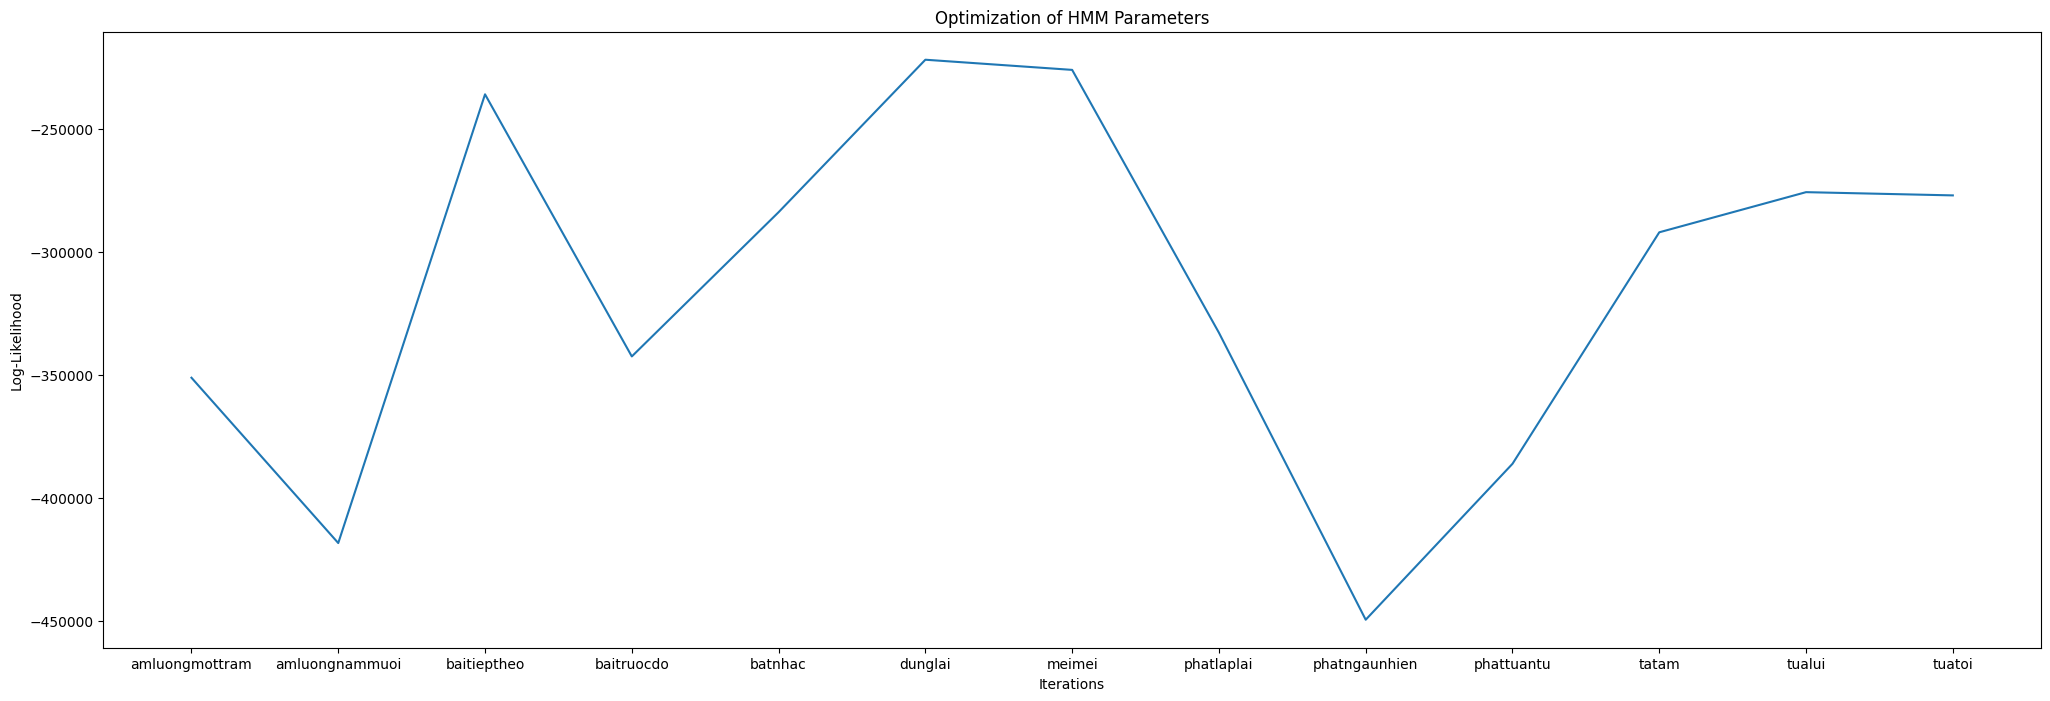

In [19]:
for cname in class_names:
    log_likelihoods = []


    x_train, x_test, y_train, y_test = train_test_split(
            all_data[cname], all_labels[cname],
            test_size=0.3,
            random_state=1
        )

    X['train'][cname] = x_train
    X['test'][cname] = x_test
    y['test'][cname] = y_test

total_train = 0
total_test = 0
for cname in class_names:
    train_count = len(X['train'][cname])
    test_count = len(X['test'][cname])
    print(cname, 'train:', train_count, '| test:', test_count)
    total_train += train_count
    total_test += test_count
print('train samples:', total_train)
print('test samples', total_test)

for idx, cname in enumerate(class_names):
    start_prob = np.full(states[idx], 0.0)
    start_prob[0] = 1.0
    trans_matrix = np.full((states[idx], states[idx]), 0.0)
    p = 0.5
    np.fill_diagonal(trans_matrix, p)
    np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
    trans_matrix[-1, -1] = 1.0

            
    print(cname)
    print(trans_matrix)

    model[cname] = hmm.GaussianHMM(
        n_components=states[idx],
        verbose=True,
        n_iter=300,
        startprob_prior=start_prob,
        transmat_prior=trans_matrix,
        params='stmc',
        init_params='stmc',
        random_state=0
    )     
    model[cname].fit(X=np.vstack(X['train'][cname]),
        lengths=[x.shape[0] for x in X['train'][cname]])
    log_likelihoods.append(model[cname].score(X=np.vstack(X['train'][cname]),
                                              lengths=[x.shape[0] for x in X['train'][cname]]))
plt.figure(figsize=(25,8))
plt.plot(range(len(class_names)), log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.xticks(range(len(class_names)), class_names)
plt.title('Optimization of HMM Parameters')
plt.show()

                        
for cname in class_names:
    name = f'{model_path}/model_{cname}.pkl'
    with open(name, 'wb') as file:
        pickle.dump(model[cname], file)

amluongmottram: 1.0
amluongnammuoi: 0.9767441860465116
baitieptheo: 0.9666666666666667
baitruocdo: 0.975
batnhac: 0.970873786407767
dunglai: 0.9758064516129032
meimei: 0.9793103448275862
phatlaplai: 0.9820359281437125
phatngaunhien: 0.9842931937172775
phattuantu: 0.985781990521327
tatam: 0.9746835443037974
tualui: 0.9767441860465116
tuatoi: 0.978494623655914


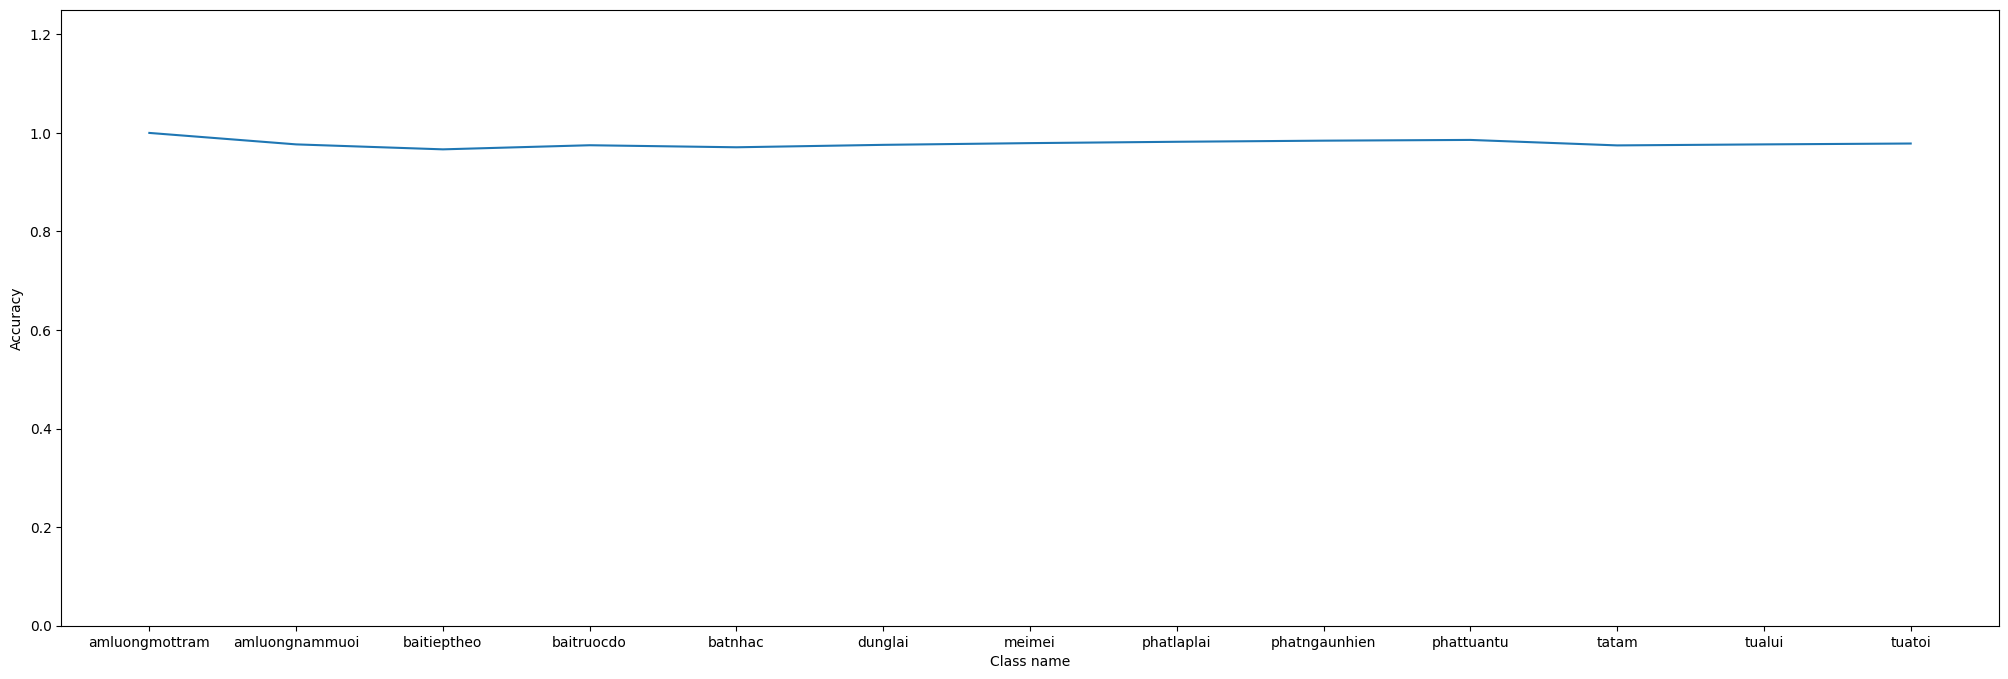

In [20]:
y_true = []
y_pred = []
accuracies = []
for cname in class_names:
    for mfcc, target in zip(X['test'][cname], y['test'][cname]):
        scores = [model[cname].score(mfcc) for cname in class_names]
        pred = np.argmax(scores)
        y_pred.append(pred)
        y_true.append(target)
    accuracy = (np.array(y_true) == np.array(y_pred)).sum() / len(y_true)
    accuracies.append(accuracy)
    print(f'{cname}:', accuracy)

plt.figure(figsize=(25,8))
plt.plot(class_names, accuracies)
plt.xlabel('Class name')
plt.ylabel('Accuracy')
plt.ylim([0, 1.25])
plt.show()


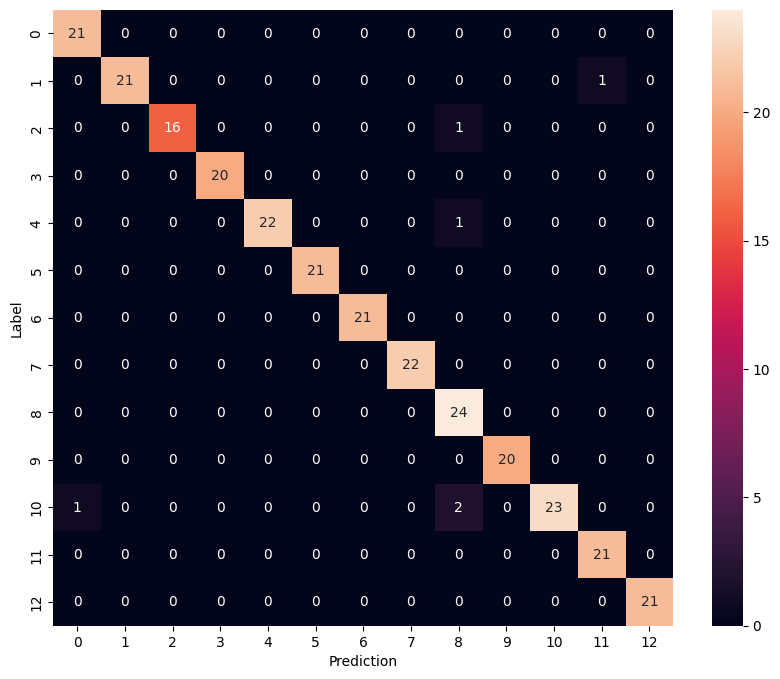

In [21]:
confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [22]:
report = classification_report( y_pred,y_true, target_names=class_names)
print(report)

                precision    recall  f1-score   support

amluongmottram       1.00      0.95      0.98        22
amluongnammuoi       0.95      1.00      0.98        21
   baitieptheo       0.94      1.00      0.97        16
    baitruocdo       1.00      1.00      1.00        20
       batnhac       0.96      1.00      0.98        22
       dunglai       1.00      1.00      1.00        21
        meimei       1.00      1.00      1.00        21
    phatlaplai       1.00      1.00      1.00        22
 phatngaunhien       1.00      0.86      0.92        28
    phattuantu       1.00      1.00      1.00        20
         tatam       0.88      1.00      0.94        23
        tualui       1.00      0.95      0.98        22
        tuatoi       1.00      1.00      1.00        21

      accuracy                           0.98       279
     macro avg       0.98      0.98      0.98       279
  weighted avg       0.98      0.98      0.98       279

